
# Python for climate data scientists

Jonas B. Sølvsteen

Theory and Modelling Seminar 26 November 2015

Main topics
---
1. Introducing Python for science
1. IPython notebook
1. Climate data tools - exploring netCDF with `xray`
1. `Pandas` syntax

State of Python for Science
---
* Python as a Matlab / Mathematica / IDL / etc. replacement has been **the future** for a long time

* By now we are there:
  1. Huge community that provides **solutions** and feedback
  2. Lots of **specialized** software based on Python
  3. **Integrated** in other software to automatize tasks (e.g. in ArcGIS or QGIS) or as front-end (e.g. for ocean model pyOM)

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('5GlNDD7qbP4', start=28, width=560, height=315) # Keynote at the 2015 SciPy Conference

# Ipython Notebook

Concept
---
* `Code`, plots, annotation, $\LaTeX$, all in one interactive file
* The file can be saved and shared
* IPython (or Julia, R, + 38 more languages) server in the background, served through browser
* [jupyter.org](http://jupyter.org/)

Benefits
---
* Reproducible research (for yourself and others)
* Easy communication and teaching
* Explore your data on a remote server (and share the results)

Graphical User Interfaces (like Matlab)
---
* [Spyder](https://pythonhosted.org/spyder/)
* [Enthought Canopy](https://www.enthought.com/products/canopy/)
* [UV-CDAT](http://uvcdat.llnl.gov/)

In [2]:
#! which spyder
#! spyder &

In [3]:
from __future__ import division, print_function

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rc('axes.formatter', limits=(-2,4))
plt.rc('figure', figsize=(12,7))

# Introducing Python for science

Python is not a scientific language 

Python is a high-level language that ties together loads of different third-party tools

Most libraries are not written in Python but in low-level compiled languages (for speed)

To do science, you need **modules**: numpy, matplotlib, scipy, pandas, netCDF4, ... (all free, all included or easily installed e.g. in [Anaconda](https://www.continuum.io/))

But you can also run code in other languages from within Python ([Matlab](http://arokem.github.io/python-matlab-bridge/), [R](http://rpy.sourceforge.net/), [Fortran](http://docs.scipy.org/doc/numpy-dev/f2py/), C, ...)

In [5]:
import numpy as np

In [6]:
a = np.array([1,2,3,4])
b = np.ones(len(a))
a - b

array([ 0.,  1.,  2.,  3.])

In [7]:
for value in a:
    if np.mod(value, 2) == 0: # even numbers
        print(value**2) # squared

4
16


In [8]:
a[np.mod(a, 2) == 0]**2

array([ 4, 16])

This syntax gets extremely powerful

Python with the available stack of modules can do all that Matlab can do, and much, much more

# Climate data science

* Big developers of dedicated Python climate tools: 
  * [UK Met office](http://scitools.org.uk/)
  * [U.S. IOOS®, Integrated Ocean Observing System](http://www.ioos.noaa.gov/) at US National Oceanic and Atmospheric Administration
  * [Lawrence Livermore National Laboratory](https://www.llnl.gov/) Utrascale Visualization Climate Data Analysis Tools ([UV-CDAT](http://uvcdat.llnl.gov/))
  * Community

* My most used tool: [xray](http://xray.readthedocs.org/) - high-level netCDF interface

In [9]:
import xray

In [10]:
#! wget http://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep.reanalysis.dailyavgs/surface_gauss/air.2m.gauss.2009.nc
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/surface_gauss/air.2m.gauss.2009.nc'
ds = xray.open_dataset(url)

In [11]:
air = ds['air']
air

<xray.DataArray 'air' (time: 365, lat: 94, lon: 192)>
[6587520 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 82.8508 80.9473 79.0435 ...
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.125 15.0 ...
  * time     (time) datetime64[ns] 2009-01-01 2009-01-02 2009-01-03 ...
Attributes:
    long_name: mean Daily Air temperature at 2 m
    units: degK
    precision: 2
    GRIB_id: 11
    GRIB_name: TMP
    var_desc: Air temperature
    dataset: NCEP Reanalysis Daily Averages
    level_desc: 2 m
    statistic: Mean
    parent_stat: Individual Obs
    actual_range: [ 175.48001099  314.63000488]
    valid_range: [ 150.  400.]
    _ChunkSize: [  1  94 192]

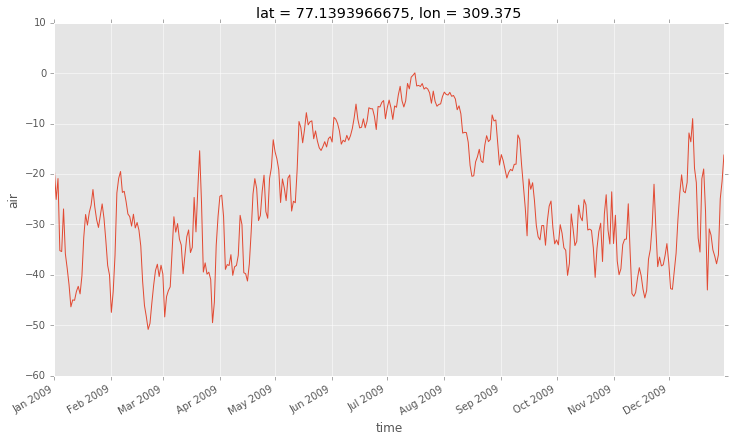

In [12]:
neemloc = dict(lat = 77.45, lon = -51.06+360)

air_neem = air.sel(method='nearest', **neemloc) - 273.15
air_neem.plot() ;

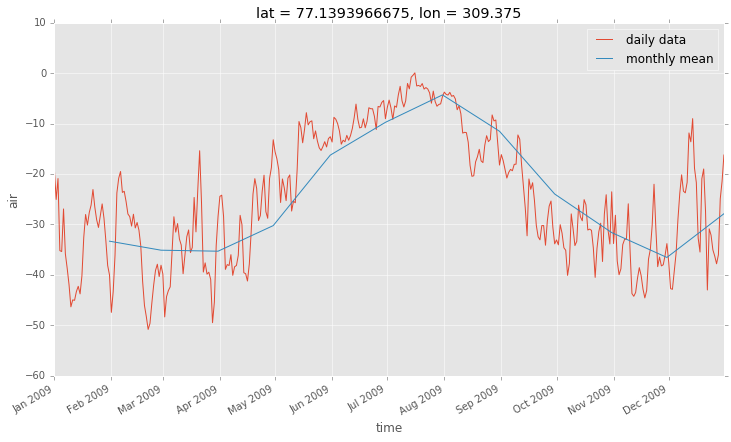

In [13]:
air_neem.plot(label='daily data')
air_neem.resample('M', dim='time', how='mean').plot(label='monthly mean')
plt.legend(loc=0) ;

In [14]:
air_neem.sel(time='2009-09-01 16:00', method='nearest')

<xray.DataArray 'air' ()>
array(-17.370001220703102)
Coordinates:
    lat      float32 ...
    lon      float32 ...
    time     datetime64[ns] 2009-09-02

SST dataset on disk
---
Extended Reconstructed Sea Surface Temperature ([ERSST](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v4)) v4 

In [15]:
#! mkdir -p "data"
#! wget "https://dl.dropboxusercontent.com/s/lxbcx4uqj3g1j02/ersst.v4.1854to2014.nc"

Or, convert the next cell to `code` and run it

%%bash

# first, go to http://www1.ncdc.noaa.gov/pub/data/cmb/ersst/v4/netcdf/
# and save it from the browser (ctrl-S) as site.html

for i in $(grep -P -o 'http\:.*?[0-9]{6}\.nc' site.html) ; do
    curl -O $i
done
if [ $? -ne 0 ] ; then
    exit 1
fi

# use ncks to make time record dimension
mkdir -p recdim
for i in *.nc ; do
    ncks --mk_rec_dmn time $i recdim/$i
done

if [ $? -ne 0 ] ; then
    exit 1
fi
# join files together
ncrcat recdim/*.nc data/ersst.v4.1854to2014.nc

In [16]:
sst = xray.open_dataset('data/ersst.v4.1854to2014.nc')['sst']
sst = sst.sel(zlev=0).reset_coords('zlev', drop=True)
sst

<xray.DataArray 'sst' (time: 1932, lat: 89, lon: 180)>
[30950640 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * time     (time) datetime64[ns] 1854-01-15 1854-02-15 1854-03-15 ...
Attributes:
    long_name: Extended reconstructed sea surface temperature
    standard_name: sea_surface_temperature
    units: degree_C
    valid_min: -300
    valid_max: 4500

In [17]:
sst_seas = sst.groupby('time.season').mean(dim='time') - sst.mean(dim='time')
sst_seas.season

<xray.DataArray 'season' (season: 4)>
array(['DJF', 'JJA', 'MAM', 'SON'], dtype=object)
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

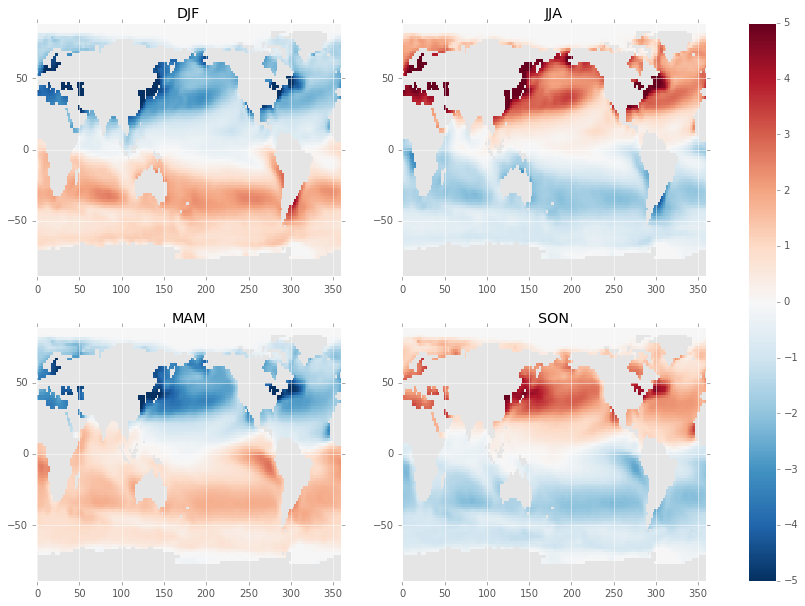

In [18]:
fig, axx = plt.subplots(ncols=2, nrows=2, figsize=(15,10))

kw = dict(add_colorbar=False, add_labels=False, vmin=-5, vmax=5)

for i, season in enumerate(sst_seas['season'].values):
    ax = axx.flat[i]
    im = sst_seas.sel(season=season).plot.imshow(ax=ax, **kw)
    ax.set_title(season)

plt.colorbar(im, ax=list(axx.flat)) ;

# Resources

Modules to leverage climate tasks:
---
* NumPy
* matplotlib
* Basemap
* Cartopy
* Iris
* CDAT / UV-CDAT
* ...

Getting started
---
1. Install Python with the [Anaconda](https://www.continuum.io/) distribution - includes science modules and makes installing others easy
1. Get an overview of the scientific module stack on [Scipy](http://scipy.org/)
1. Use Python 3

Examples
---
* [EarthPy](http://earthpy.org/) - Earth science python examples (plotting things on maps, netCDF, ...)
* [python4oceanographers](http://ocefpaf.github.io/python4oceanographers/) - many ocean/climate related examples
* [Software Carpentry](http://software-carpentry.org/) - Courses on scientific programming with Python/Matlatb/R
* [Pythonic Perambulations](http://jakevdp.github.io/) - Jake Vanderplas' blog
* [IPython notebook slideshow mode](https://github.com/damianavila/RISE) - powered by reveal.js

More `xray` tutorials
---
* https://github.com/Unidata/unidata-users-workshop/blob/master/notebooks/xray-tutorial.ipynb
* http://nbviewer.ipython.org/github/nicolasfauchereau/metocean/blob/master/notebooks/xray.ipynb
* https://ocefpaf.github.io/python4oceanographers/blog/2014/12/22/xray/

# Thanks!

One more cool thing: interactive plots
---

In [19]:
import mpld3
from mpld3 import plugins

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = ax[::-1]

X = np.random.normal(size=(3, 100))
for i in range(3):
    for j in range(3):
        ax[i, j].xaxis.set_major_formatter(plt.NullFormatter())
        ax[i, j].yaxis.set_major_formatter(plt.NullFormatter())
        points = ax[i, j].scatter(X[j], X[i])
        
plugins.connect(fig, plugins.LinkedBrush(points))

mpld3.display()